# read the files and plot them

In [1]:
import numpy as np # conda activate crytrad
import pandas as pd
import mplfinance as mpf
import os
from glob import glob
import matplotlib.pyplot as plt
%matplotlib inline
from collections import Counter
import mplfinance as mpf

# read data with the same ticker with the same interval into 1 dataframe

In [2]:
tickerpair="BTCUSDT"
interval="30m"

In [3]:
intervals=['1m','3m','5m','15m','30m','1h','2h','3h','4h','6h','8h','12h','1d','3d','1w','1Month']
years=sorted(set([g.split("_")[2] for g in glob(f"kline_data\\{tickerpair}/*")]))

In [4]:
%%time
df = [pd.read_csv(g) for g in sorted(glob(f"kline_data\\{tickerpair}/*")) if f"_{interval}.csv" in g]
df = pd.concat(df, ignore_index=True).drop_duplicates().reset_index(drop=True)

CPU times: total: 266 ms
Wall time: 422 ms


In [5]:
## formating for mplfinance
dfmpl=df[["open_time","open","high","low","close","volume"]]
dfmpl = dfmpl.rename(columns={"open_time":"Date","open":"Open","high":"High","low":"Low","close":"Close","volume":"Volume"})
dfmpl=dfmpl.set_index("Date")
dfmpl.index = pd.to_datetime(dfmpl.index,unit="ms")
print(len(dfmpl))
dfmpl=dfmpl.iloc[-10000:]

93105


In [28]:
input_dim = 5
hidden_dim = 10
num_layers = 2
output_dim = 1
num_epochs = 20

In [29]:
#mpf.plot(dfmpl,type="ohlc")

In [30]:
import torch
torch.cuda.is_available(),torch.cuda.device_count(),torch.cuda.current_device(),torch.cuda.get_device_name(0)

(True, 1, 0, 'NVIDIA GeForce 940M')

In [31]:
def split_data(stock, lookback):
    close_index = 3
    data_raw = stock.to_numpy() # convert to numpy array
    data = []
    
    # create all possible sequences of length seq_len
    for index in range(len(data_raw) - lookback): 
        data.append(data_raw[index: index + lookback])
    
    data = np.array(data);
    test_set_size = int(np.round(0.2*data.shape[0]));
    train_set_size = data.shape[0] - test_set_size;
    
    x_train = data[:train_set_size,:-1]
    y_train = data[:train_set_size,-1]
    a=y_train
    b=x_train[:,0]
    y_train = np.divide(a, b, out=np.zeros_like(a), where=b!=0)[:,[close_index]]
    a=x_train
    b=x_train[:,0][:,None,:]
    x_train = np.divide(a, b, out=np.zeros_like(a), where=b!=0)
    
    x_test = data[train_set_size:,:-1]
    y_test = data[train_set_size:,-1]
    a=y_test
    b=x_test[:,0]
    y_test = np.divide(a, b, out=np.zeros_like(a), where=b!=0)[:,[close_index]]
    a=x_test
    b=x_test[:,0][:,None,:]
    x_test = np.divide(a, b, out=np.zeros_like(a), where=b!=0)
    
    return [x_train, y_train, x_test, y_test]
lookback = 20 # choose sequence length
x_train0, y_train0, x_test0, y_test0 = split_data(dfmpl, lookback)

In [32]:
import torch
import torch.nn as nn
x_train = torch.from_numpy(x_train0).type(torch.Tensor).cuda()
x_test = torch.from_numpy(x_test0).type(torch.Tensor).cuda()
y_train_lstm = torch.from_numpy(y_train0).type(torch.Tensor).cuda()
y_test_lstm = torch.from_numpy(y_test0).type(torch.Tensor).cuda()
y_train_gru = torch.from_numpy(y_train0).type(torch.Tensor).cuda()
y_test_gru = torch.from_numpy(y_test0).type(torch.Tensor).cuda()
print(x_train.shape,x_test.shape)

torch.Size([7984, 19, 5]) torch.Size([1996, 19, 5])


In [33]:
class LSTM(nn.Module):
    def __init__(self, input_dim, hidden_dim, num_layers, output_dim):
        super(LSTM, self).__init__()
        self.hidden_dim = hidden_dim
        self.num_layers = num_layers
        
        self.lstm = nn.LSTM(input_dim, hidden_dim, num_layers, batch_first=True).cuda()
        self.fc = nn.Linear(hidden_dim, output_dim).cuda()
    def forward(self, x):
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_dim).requires_grad_().cuda()
        c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_dim).requires_grad_().cuda()
        out, (hn, cn) = self.lstm(x, (h0.detach(), c0.detach()))
        out = self.fc(out[:, -1, :]) 
        return out

In [34]:
modellstm = LSTM(input_dim=input_dim, hidden_dim=hidden_dim, output_dim=output_dim, num_layers=num_layers).cuda()
criterion = torch.nn.MSELoss(reduction='mean').cuda()
optimiser = torch.optim.Adam(modellstm.parameters(), lr=0.01)

In [35]:
import time
hist = np.zeros(num_epochs)
start_time = time.time()
lstm = []
for t in range(num_epochs):
    y_train_pred = modellstm(x_train)
    loss = criterion(y_train_pred, y_train_lstm)
    #print("Epoch ", t, "MSE: ", loss.item())
    hist[t] = loss.item()
    optimiser.zero_grad()
    loss.backward()
    optimiser.step()
    
training_time = time.time()-start_time
print("Training time: {}".format(training_time))

Training time: 1.5131535530090332


In [36]:
class GRU(nn.Module):
    def __init__(self, input_dim, hidden_dim, num_layers, output_dim):
        super(GRU, self).__init__()
        self.hidden_dim = hidden_dim
        self.num_layers = num_layers
        
        self.gru = nn.GRU(input_dim, hidden_dim, num_layers, batch_first=True).cuda()
        self.fc = nn.Linear(hidden_dim, output_dim).cuda()

    def forward(self, x):
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_dim).requires_grad_().cuda()
        out, (hn) = self.gru(x, (h0.detach()))
        out = self.fc(out[:, -1, :]) 
        return out

In [37]:
modelgru = GRU(input_dim=input_dim, hidden_dim=hidden_dim, output_dim=output_dim, num_layers=num_layers).cuda()
criterion = torch.nn.MSELoss(reduction='mean').cuda()
optimiser = torch.optim.Adam(modelgru.parameters(), lr=0.01)

In [38]:
import time
hist = np.zeros(num_epochs)
start_time = time.time()
lstm = []
for t in range(num_epochs):
    y_train_pred = modelgru(x_train)
    loss = criterion(y_train_pred, y_train_lstm)
    #print("Epoch ", t, "MSE: ", loss.item())
    hist[t] = loss.item()
    optimiser.zero_grad()
    loss.backward()
    optimiser.step()
    
training_time = time.time()-start_time
print("Training time: {}".format(training_time))

Training time: 1.467747688293457


Text(0.5, 1.0, 'lstm')

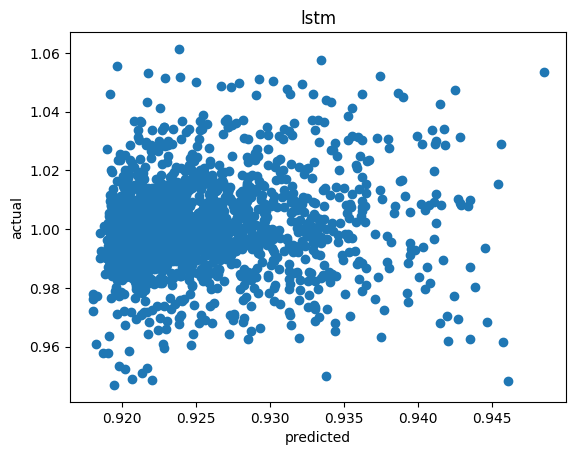

In [39]:
pred = modellstm(x_test).cpu().detach().numpy().T[0]
actu = y_test_lstm.cpu().detach().numpy().T[0]
plt.scatter(pred,actu)
plt.ylabel("actual")
plt.xlabel("predicted")
plt.title("lstm")

Text(0.5, 1.0, 'gru')

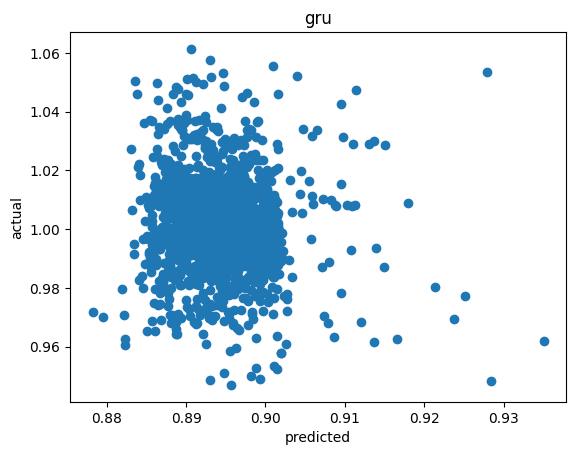

In [40]:
pred = modelgru(x_test).cpu().detach().numpy().T[0]
actu = y_test_gru.cpu().detach().numpy().T[0]
plt.scatter(pred,actu)
plt.ylabel("actual")
plt.xlabel("predicted")
plt.title("gru")